# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [4]:
all_survey = pandas.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Generating bar plot of correlation between the survey fields and SAT scores

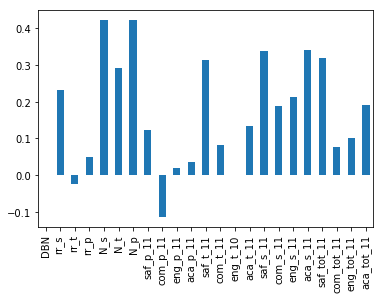

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

combined.corr()['sat_score'][survey_fields].plot.bar()
plt.show()

There is a high correlation of safety according to students and sat scores and safety according to teachers and sat scores. This shows that the perception of safety in a learning environment plays a role in higher or lower sat scores. Other notable high correlations are N_s/N_p and sat_scores.

# Generating scatter plot of saf_s_11 (safety according to students) vs. sat_score

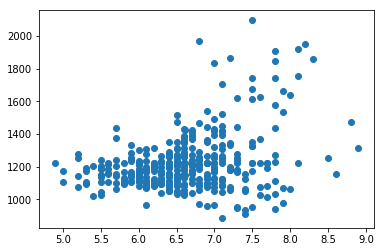

In [13]:
fig, ax = plt.subplots()

ax.scatter(combined['saf_s_11'],combined['sat_score'])

# or:
# combined.plot.scatter("saf_s_11", "sat_score")
plt.show()

There seems to be some postitive correlation between the two. Low safety scores do not seem to be correlated with high test scores. High safety scores seem to be spread out along high and low test scores. 

# Finding average safety score in each district and mapping results

In [14]:
avg_saf = combined.groupby("school_dist").agg(numpy.mean)
avg_saf.reset_index(inplace=True)

/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


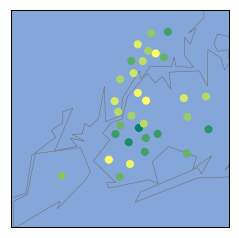

In [15]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = avg_saf["lon"].tolist()
latitudes = avg_saf["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=avg_saf["saf_s_11"], cmap="summer")
plt.show()

From glancing at the results, it appears that the northern part of Brooklyn has 6 or 7 districts with lower safety scores. One district in southern Queens and one district in the Bronx also have low scores. Southern Brooklyn and most of Queens seem to have good safety scores.

# Investigating racial differences in SAT scores

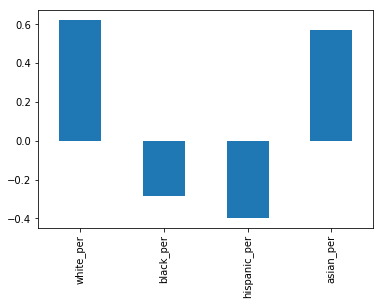

In [16]:
race = ['white_per', 'black_per', "hispanic_per", 'asian_per']

combined.corr()['sat_score'][race].plot.bar()
plt.show()

There is a high positive correlation between white percent and sat_score and asian percent and sat_score. High negative correlation between hispanic_per and sat_score.

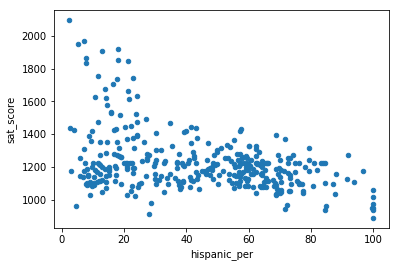

In [17]:
combined.plot.scatter('hispanic_per', 'sat_score')
plt.show()

In [18]:
hisp_schools = combined[combined['hispanic_per'] > 95]
print (hisp_schools['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools seem to be international schools and most of the students might be learning English as a second language which explains lower SAT scores. 

In [19]:
hisp_schools_10 = combined[combined['hispanic_per'] < 10]
hisp_schools_10 = hisp_schools_10[hisp_schools_10['sat_score'] > 1800]
print (hisp_schools_10)

        DBN                                        SCHOOL NAME  \
37   02M475                             STUYVESANT HIGH SCHOOL   
151  10X445                       BRONX HIGH SCHOOL OF SCIENCE   
187  13K430                     BROOKLYN TECHNICAL HIGH SCHOOL   
327  28Q687  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...   
356  31R605                STATEN ISLAND TECHNICAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
37                     832                            679.0   
151                    731                            632.0   
187                   1277                            587.0   
327                    121                            612.0   
356                    227                            635.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
37                 735.0                   682.0     2096.0   
151                688.0                   649.0     1969.0   
187                659.0           

Schools in this list are all high rated technical schools in New York.

# Bar plot of correlations between male and female percent vs. SAT scores

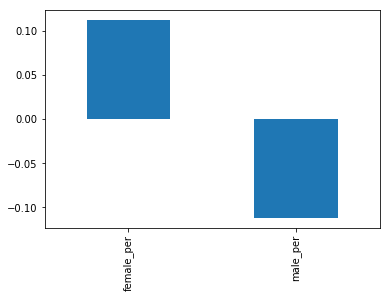

In [20]:
male_female = ['female_per', 'male_per']
combined.corr()['sat_score'][male_female].plot.bar()
plt.show()

Neither correlation is extremly strong but high female percent is positively correlated with high SAT scores and high male percent is negatively correlated with high SAT scores.

# Schools with high SAT scores and female percent

In [21]:
high = combined[combined['sat_score'] > 1700]
high = high[high['female_per'] > 60]
print (high['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


# Scatter plot of female percent vs. SAT score

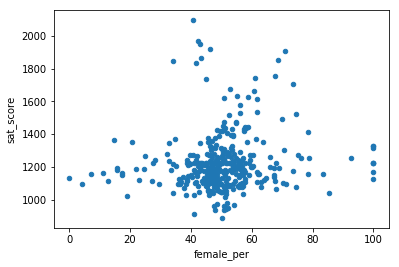

In [22]:
combined.plot.scatter('female_per','sat_score')
plt.show()

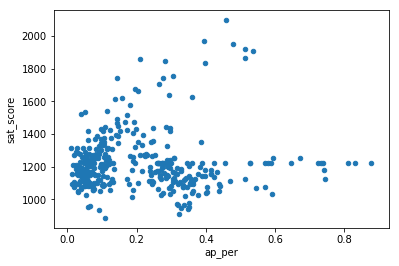

In [23]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter('ap_per','sat_score')
plt.show()

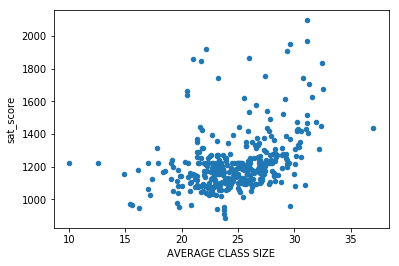

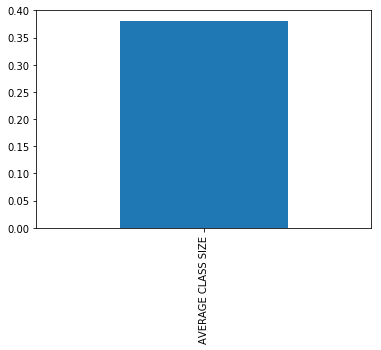

In [24]:

combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')
plt.show()

classs = ['AVERAGE CLASS SIZE']
combined.corr()['sat_score'][classs].plot.bar()
plt.show()